# Bayesian modeling of long COVID Data

The data comes from the 2023 National Health Interview Survey conducted by the CDC.

Let $Y_i$ be the indicator variable showing whether individual $i$ self-reported long COVID.  Say we have k features used as predictors in a model.  The long covid outcome will be modeled by a logistic regression:


$$
\begin{split}
\mathbf{x} & \in \mathbb{R}^k
\\ \\
Y_{i} & \sim \text{Bernoulli}(p_{i})
\\ \\
\text{logit}\:p_{i} &= \beta_{0} + \beta_1 \times x_1 + \beta_2 \times x_2 + \dots + \beta_k \times x_k
\\ \\
\end{split}
$$

The coefficients, $\beta$, will be modeled with normal distributions so that they can take on both negative and positive values. 

## Imports and data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

import preprocessing_clean as ppc

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# HELPER FN
def get_preds(trace):
    p_test_pred = trace.posterior_predictive["obs"].mean(dim=["chain", "draw"])
    y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()
    return p_test_pred, y_test_pred

def plot_roc(y_true, p_pred, title="ROC"):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots()
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
    x = np.linspace(0,1)
    y = x
    plt.plot(x,y, linestyle='--')
    ax.set(title=title);

In [4]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'

## 1. Simple Model: Three variables

First, I will start with a simplified model with only 3 predictors. 
$$
\begin{split}
\text{logit}\:p_{i} &= \beta_{0} + \beta_1 \times \text{age} + \beta_2 \times \text{is male}  + \beta_k \times \text{got covid vaccine}
\end{split}
$$

In [5]:
X_train_s, X_test_s, y_train_s, y_test_s = ppc.preprocess_simple_model(df_full)

# Define PyMC model
with pm.Model() as simple_model:
    # predictors
    X = pm.Data("X", X_train_s.values)
    y = pm.Data("y", y_train_s)

    # coefficient priors
    b0 = pm.Normal('b0', mu=0, sigma=10)   
    b1 = pm.Normal('b1', mu=0, sigma=10)
    b2 = pm.Normal('b2', mu=0, sigma=10)
    b3 = pm.Normal('b3', mu=0, sigma=10)
    
    # calculate probability
    logitp = b0 + b1*X[:,0] + b2*X[:,1] + b3*X[:,2]
    theta = 1 / (1 + np.exp(-logitp))
    # likelihood
    obs = pm.Bernoulli('obs', p=theta, observed=y) 
simple_model

Shape after feature selection and dropping lcovid nulls: (15291, 4)


 b0 ~ Normal(0, 10)
 b1 ~ Normal(0, 10)
 b2 ~ Normal(0, 10)
 b3 ~ Normal(0, 10)
obs ~ Bernoulli(f(b3, b2, b0, b1))

In [6]:
with simple_model:
    idata_simple = pm.sample_smc()
    print(f'DONE')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

DONE


In [7]:
pm.summary(idata_simple)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,-1.441,0.086,-1.608,-1.283,0.001,0.001,7966.0,7791.0,1.0
b1,0.003,0.001,-0.000,0.005,0.000,0.000,7642.0,7866.0,1.0
b2,-0.458,0.051,-0.554,-0.362,0.001,0.000,8215.0,7770.0,1.0
b3,-0.240,0.061,-0.359,-0.130,0.001,0.000,8276.0,8101.0,1.0


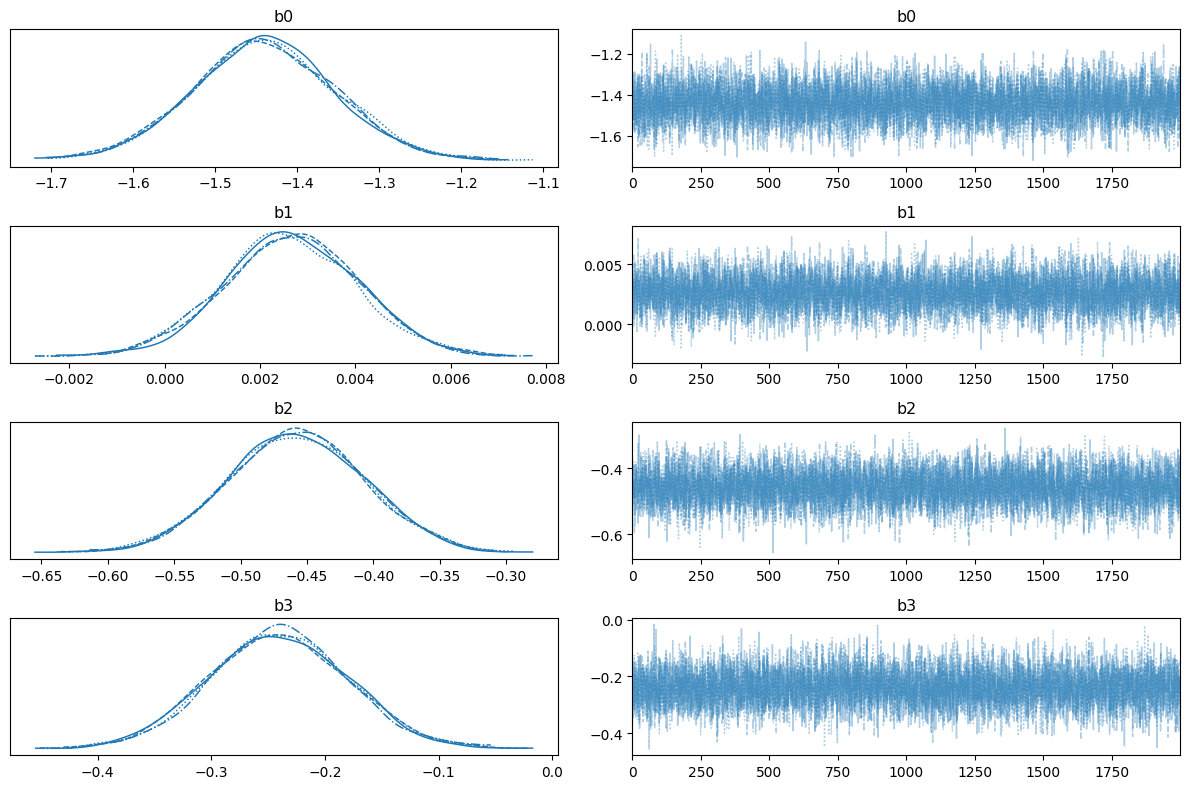

In [8]:
pm.plot_trace(idata_simple)
plt.tight_layout()
plt.show()

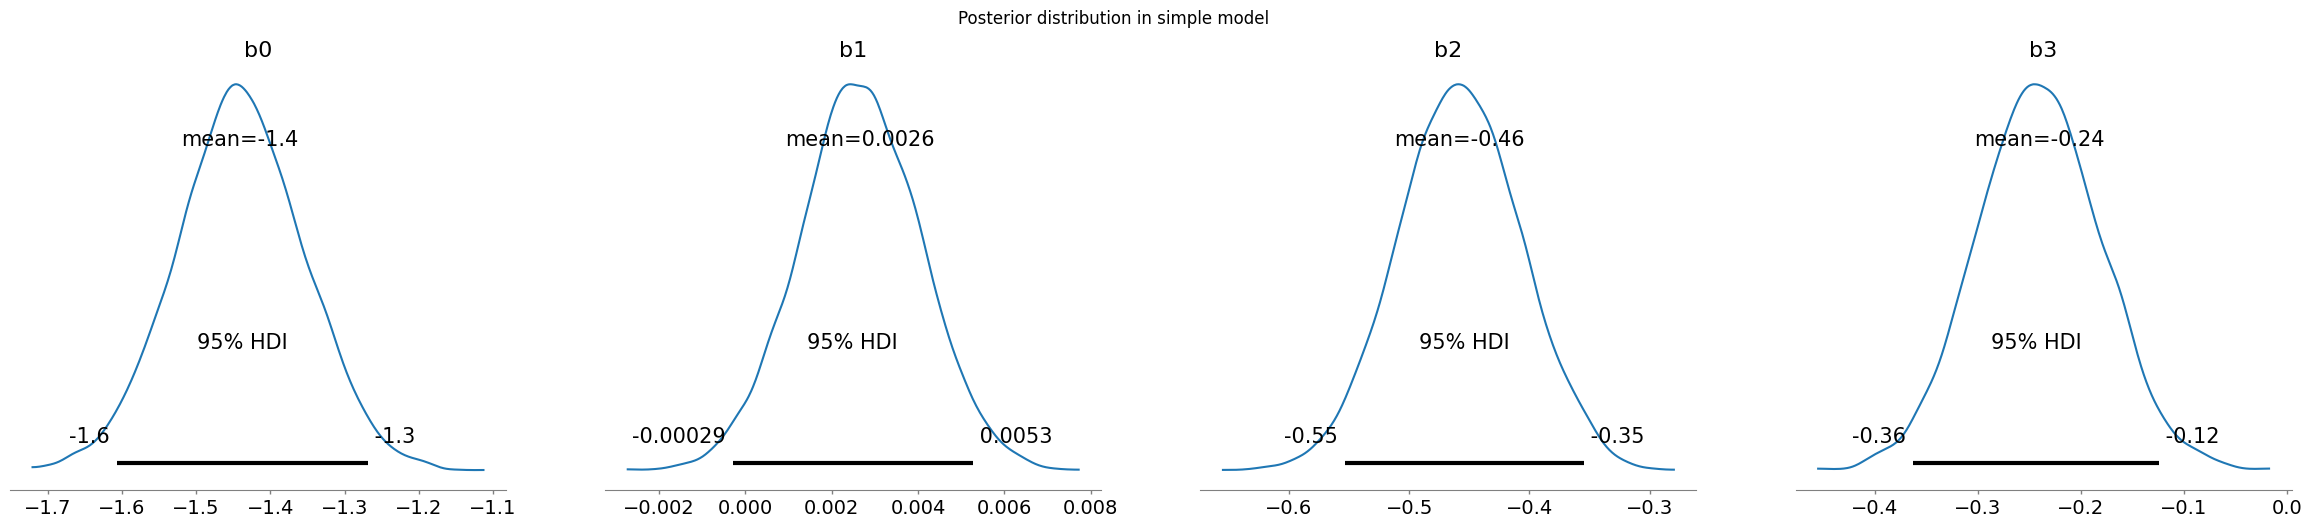

In [9]:
# plot posterior distributions
posterior_dict = {}
params = ["b0", "b1", "b2", "b3"]
for param in params:
    posterior_dict[param] = idata_simple.posterior[param].values

az.plot_posterior(posterior_dict, hdi_prob=0.95);
plt.suptitle("Posterior distribution in simple model")
plt.show()

## 2. Literature model:
This model uses features chosen from existing risk factors in the literature, where present in the dataset:

- "SEX_A" : female sex
- "DIBEV_A" : type 2 diabetes
- "AGEP_A" : increasing age
- "BMICAT_A" : increasing BMI 
- "COGMEMDFF_A" : difficulty concentrating (closest to the risk factor of ADHD) 
- the role of the vaccine in providing protection against long COVID is unclear:
  - "SHTCVD191_A" : yes/no got covid vaccine
  - "SHTCVD19NM1_A" : number of covid vaccines
  - "SHOTTYPE2_A" : brand of first covid vaccine
- "HISPALLP_A " : race where hipanic heritage is distinguished

In [10]:
X_train_l, X_test_l, y_train_l, y_test_l = ppc.preprocess_lit_features(df_full)
coords_l = {"coeffs": X_train_l.columns}

with pm.Model(coords=coords_l) as lit_model:
    X = pm.Data("X", X_train_l)
    y = pm.Data("y", y_train_l)
    
    # priors
    b0 = pm.Normal("b0", 0, 100) # intercept: no shrinkage
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    
    # linear model
    mu = b0 + pm.math.dot(X, b)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    pm.Bernoulli("obs", p=p, observed=y)
lit_model

 b0 ~ Normal(0, 100)
  b ~ Normal(0, 1)
  p ~ Deterministic(f(b, b0))
obs ~ Bernoulli(p)

In [11]:
with lit_model:
    idata_lit = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [12]:
az.summary(idata_lit, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[AGEP_A],0.013,0.028,-0.039,0.066,0.000,0.000,7804.0,7756.0,1.0
b[SEX_A_2],0.460,0.054,0.357,0.560,0.001,0.000,7793.0,7766.0,1.0
b[SEX_A_7],0.773,0.934,-0.967,2.555,0.010,0.007,8083.0,8076.0,1.0
b[SEX_A_9],0.017,1.001,-1.936,1.790,0.011,0.008,7797.0,7807.0,1.0
b[DIBEV_A_2],-0.399,0.079,-0.552,-0.253,0.001,0.001,7774.0,6797.0,1.0
b[DIBEV_A_7],-0.694,0.812,-2.223,0.808,0.009,0.007,7936.0,7932.0,1.0
b[DIBEV_A_9],-0.008,0.994,-1.886,1.870,0.011,0.008,7600.0,7377.0,1.0
b[BMICAT_A_2],-0.069,0.215,-0.465,0.344,0.002,0.002,7830.0,7237.0,1.0
b[BMICAT_A_3],0.128,0.215,-0.257,0.549,0.002,0.002,7809.0,7483.0,1.0
b[BMICAT_A_4],0.335,0.214,-0.052,0.747,0.002,0.002,7833.0,7880.0,1.0


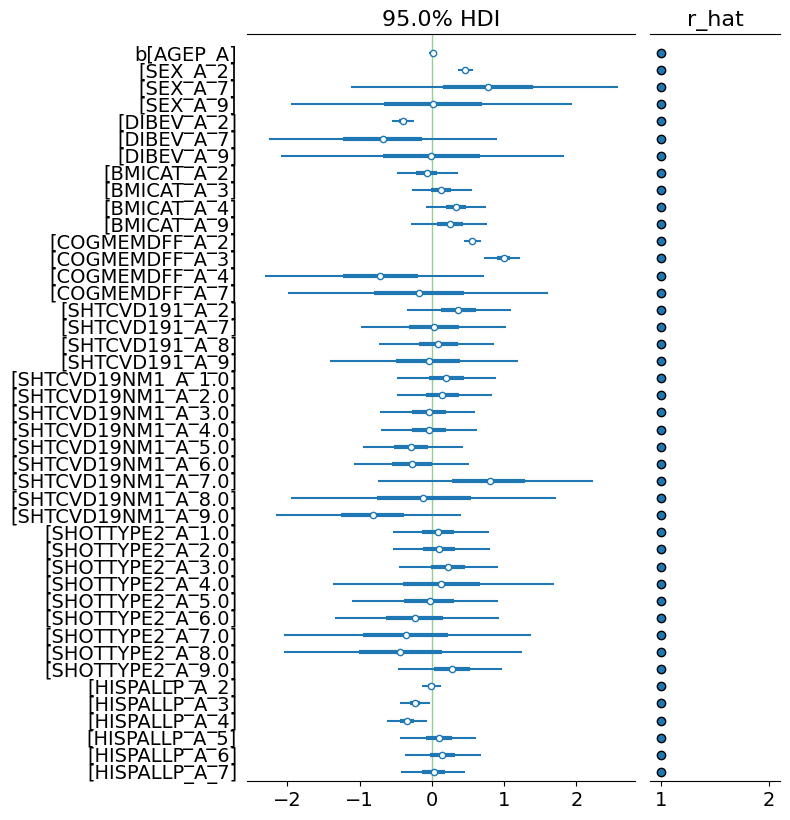

In [13]:
az.plot_forest(idata_lit, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));
plt.tight_layout()

## 3. Sparse model:

This model uses features selected by shrinking coefficients with a sparsity-enforcing prior in a hierarchical model. 

The features selected are the following: 
- 'BALDIZZ_A' : Balance or dizziness problem past 12 months
- 'PAIHDFC3M_A' : Migraine
- 'HRLOUDJOB_A' : Ever exposed to loud noise at job
- 'ASEV_A' : Ever had asthma
- 'SEX_A' : Sex of Sample Adult
- 'HYSTEV2_A' : Had hysterectomy
- 'PAIAMNT_A' : How much pain last time
- 'SHTCVD19NM1_A' : Number of COVID-19 vaccinations
- 'CFSEV_A' : Ever had Chronic Fatigue Syndrome

In [14]:
X_train_b, X_test_b, y_train_b, y_test_b = ppc.preprocess_bayes(df_full)
coords_b = {"coeffs": X_train_b.columns}

with pm.Model(coords=coords_b) as bayes_model:
    X = pm.Data("X", X_train_b)
    y = pm.Data("y", y_train_b)
    
    # priors
    b0 = pm.Normal("b0", 0, 100)
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    
    # linear model
    mu = b0 + pm.math.dot(X, b)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    pm.Bernoulli("obs", p=p, observed=y)
bayes_model

 b0 ~ Normal(0, 100)
  b ~ Normal(0, 1)
  p ~ Deterministic(f(b, b0))
obs ~ Bernoulli(p)

In [15]:
with bayes_model:
    idata_bayes = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [16]:
az.summary(idata_bayes, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[BALDIZZ_A_2],-0.541,0.059,-0.646,-0.425,0.001,0.000,7908.0,7687.0,1.0
b[BALDIZZ_A_7],-0.026,0.784,-1.501,1.469,0.009,0.007,6906.0,7556.0,1.0
b[BALDIZZ_A_8],-0.069,0.561,-1.171,0.927,0.006,0.004,7909.0,7766.0,1.0
b[BALDIZZ_A_9],-0.236,0.768,-1.588,1.273,0.009,0.006,8005.0,7846.0,1.0
b[PAIHDFC3M_A_2],0.154,0.070,0.023,0.286,0.001,0.001,7691.0,7674.0,1.0
b[PAIHDFC3M_A_3],0.475,0.099,0.296,0.661,0.001,0.001,7823.0,7755.0,1.0
b[PAIHDFC3M_A_4],0.231,0.100,0.039,0.412,0.001,0.001,7928.0,8011.0,1.0
b[PAIHDFC3M_A_7],-0.501,0.867,-2.144,1.098,0.010,0.007,7921.0,8055.0,1.0
b[PAIHDFC3M_A_8],-0.400,0.698,-1.711,0.904,0.008,0.005,8192.0,7637.0,1.0
b[PAIHDFC3M_A_9],-0.147,0.947,-1.892,1.655,0.011,0.008,8013.0,7306.0,1.0


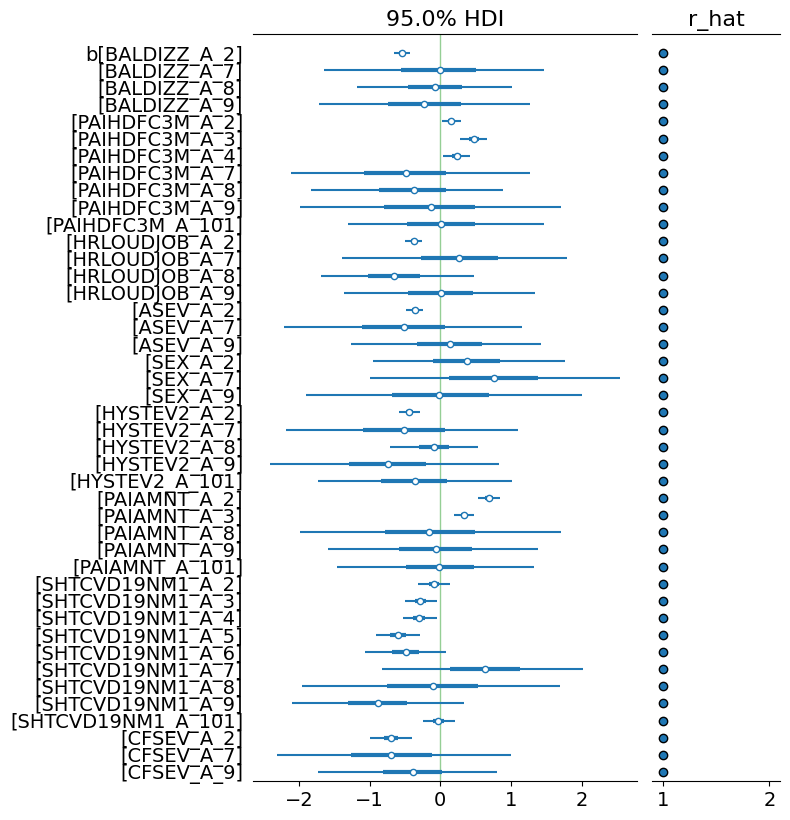

In [17]:
az.plot_forest(idata_bayes, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));
plt.tight_layout()

## 4. Model from Chi-squared-selected Features

Top features resulting from Chi-squared feature selections.  The ones used for the model are starred (selected to prevent multicollinearity)

- 'MHRX_A', : Took medication for other emotions/concentration/behavior/mental health, past 12 months ***
- 'PAILLMB3M_A', : Pain in hips
- 'PAIULMB3M_A', : Pain in hands
- 'FDSCAT3_A', : Adult 3 category food security recode  *** 
- 'ANXLEVEL_A', : Level of feelings when last felt worried/nervous/anxious ***
- 'PAIWKLM3M_A', : How often pain limits life or work ***
- 'EMERG12MTC_A', : Number of times visited hospital emergency room, past 12 months, top-coded ***
- 'DISCRIM3_A', :  Treated as not smart ***
- 'PHQ43_A', : How often felt nervous/anxious/on edge, past 2 weeks
- 'PHQ44_A', :  How often can't stop/control worrying, past 2 weeks
- 'PAIBACK3M_A', : Back pain
- 'PHQ41_A', : How often little interest in things, past 2 weeks
- 'FDSCAT4_A', : Adult 4 category food security recode 
- 'FDSRUNOUT_A', : Worry food would run out
- 'BALDIZZ_A', : Balance or dizziness problem past 12 months *** 
- 'PAIAMNT_A', : How much pain last time
- 'PAIFRQ3M_A', : How often had pain, past 3 months
- 'PHQ42_A', : How often feeling down, past 2 weeks
- 'PAIAPG3M_A', : Abdominal pain
- 'DEPFREQ_A', : How often depressed
- 'PAITOOTH3M_A', : Toothache or jaw pain
- 'DEPLEVEL_A', : Level of how depressed ***
- 'PAIAFFM3M_A', : How often pain impacts family
- 'PAIHDFC3M_A' : Migraine

In [18]:
X_train_c, X_test_c, y_train_c, y_test_c = ppc.preprocess_chi(df_full)

coords_c = {"coeffs":X_train_c.columns}

with pm.Model(coords=coords_c) as chi_model:
    # data containers
    X = pm.Data("X", X_train_c.values)
    y = pm.Data("y", y_train_c)
    # priors
    b0 = pm.Normal("b0", 0, 100) # intercept: no shrinkage
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = b0 + pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)
chi_model


 b0 ~ Normal(0, 100)
  b ~ Normal(0, 1)
  p ~ Deterministic(f(b, b0))
obs ~ Bernoulli(p)

In [19]:
with chi_model:
    idata_chi = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [20]:
az.summary(idata_chi, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[MHRX_A_2],-0.055,0.154,-0.344,0.240,0.002,0.001,7751.0,7888.0,1.0
b[MHRX_A_7],0.491,0.691,-0.833,1.766,0.008,0.006,7991.0,7848.0,1.0
b[MHRX_A_8],-0.330,0.899,-2.003,1.354,0.010,0.007,8121.0,7517.0,1.0
b[MHRX_A_9],-0.176,0.732,-1.547,1.204,0.008,0.006,7817.0,7733.0,1.0
b[MHRX_A_101],0.033,0.158,-0.260,0.338,0.002,0.001,7958.0,7957.0,1.0
b[FDSCAT3_A_2],0.323,0.108,0.116,0.520,0.001,0.001,7834.0,7633.0,1.0
b[FDSCAT3_A_3],0.595,0.112,0.379,0.796,0.001,0.001,8200.0,7630.0,1.0
b[FDSCAT3_A_8],0.023,0.246,-0.454,0.469,0.003,0.002,7669.0,7960.0,1.0
b[ANXLEVEL_A_2],0.266,0.095,0.096,0.448,0.001,0.001,7684.0,7781.0,1.0
b[ANXLEVEL_A_3],0.002,0.069,-0.128,0.130,0.001,0.001,7881.0,8143.0,1.0


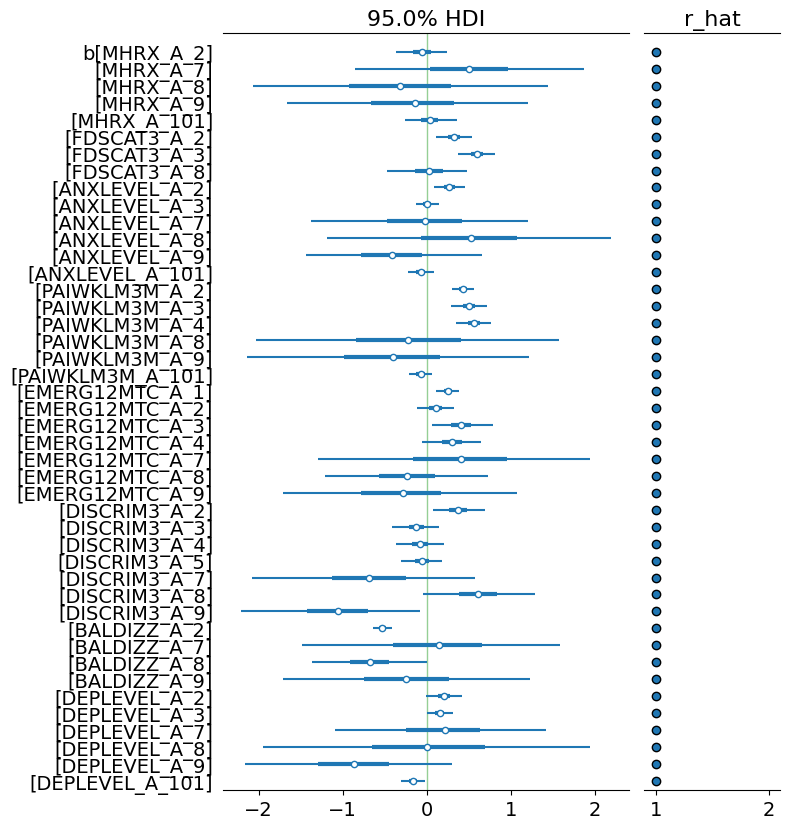

In [21]:
az.plot_forest(idata_chi, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0, 0));
plt.tight_layout()

## Model Selection using Bayes Factor

see: https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html

The metric presented here is twice the natural log of the Bayes factor, which is helpful for interpretation according to Kass and Raferty (1995).

In [22]:
def log_marginal_likelihood(trace):
    """The trace must be from SMC sampling"""
    if np.isnan(trace.sample_stats['log_marginal_likelihood'][0][0].item()).shape == tuple():
        lml =  trace.sample_stats['log_marginal_likelihood'].mean().item()
    else:
        log_marginal_likelihood = trace.sample_stats['log_marginal_likelihood'][0]
        listed = [sublist.item() for sublist in log_marginal_likelihood]
        not_nans = [value for sublist in listed for value in sublist if not np.isnan(value)]
        lml = np.mean(not_nans)
    return lml

def calculate_bf(trace1, trace2):
    """Twice the natural log of bayes factor."""
    return 2*(log_marginal_likelihood(trace1) - log_marginal_likelihood(trace2))

In [23]:
## BAYES FACTORS
bayes_factors = {
    "Lit:Simple" : calculate_bf(idata_lit, idata_simple),
    "Bayes:Simple" : calculate_bf(idata_bayes, idata_simple),
    "Bayes:Lit" : calculate_bf(idata_bayes, idata_lit),
    "Chi:Simple" : calculate_bf(idata_chi, idata_simple),
    "Chi:Lit" : calculate_bf(idata_chi, idata_lit),
    "Bayes:Chi" : calculate_bf(idata_bayes, idata_chi)
}
pd.DataFrame({"models":bayes_factors.keys(), "2*lnBF":bayes_factors.values()})

,models,2*lnBF
0,Lit:Simple,177.448605
1,Bayes:Simple,541.612781
2,Bayes:Lit,364.164176
3,Chi:Simple,422.996689
4,Chi:Lit,245.548084
5,Bayes:Chi,118.616092


## Evaluation on the test set

In [24]:
with simple_model:
    pm.set_data({"X": X_test_s.values, "y": y_test_s})
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple))

with lit_model:
    pm.set_data({"X": X_test_l.values, "y": y_test_l})
    idata_lit.extend(pm.sample_posterior_predictive(idata_lit))

with bayes_model:
    pm.set_data({"X": X_test_b.values, "y": y_test_b})
    idata_bayes.extend(pm.sample_posterior_predictive(idata_bayes))

with chi_model:
    pm.set_data({"X": X_test_c.values, "y": y_test_c})
    idata_chi.extend(pm.sample_posterior_predictive(idata_chi))

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

Sampling: [obs]


Output()

In [25]:
p_test_pred_simple, y_test_pred_simple = get_preds(idata_simple)
p_test_pred_lit, y_test_pred_lit = get_preds(idata_lit)
p_test_pred_bayes, y_test_pred_bayes = get_preds(idata_bayes)
p_test_pred_chi, y_test_pred_chi = get_preds(idata_chi)

p_preds = [p_test_pred_simple, p_test_pred_lit, p_test_pred_bayes, p_test_pred_chi] ## ADD HERE
model_names = ["Simple", "Literature", "Sparse Bayes", "Chi Selection"]

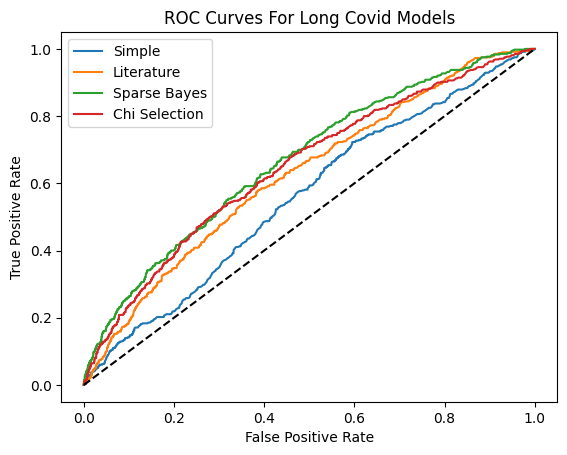

In [26]:
# PLOT ROCS
roc_aucs = []

for p_pred, model_name in zip(p_preds, model_names):
    fpr, tpr, thresholds = roc_curve(
        y_true=y_test_s, y_score=p_pred, pos_label=1, drop_intermediate=False
    )
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    
    # fig, ax = plt.subplots()
    plt.plot(fpr, tpr, label={model_name})
    x = np.linspace(0,1)
    y = x
plt.plot(x,y, linestyle='--', color='black')
plt.legend()
plt.title("ROC Curves For Long Covid Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [27]:
pd.DataFrame({"Model":model_names, "roc-auc": roc_aucs}).round(2)

,Model,roc-auc
0,Simple,0.56
1,Literature,0.62
2,Sparse Bayes,0.67
3,Chi Selection,0.65
